# Geo-spatial fencing for theft prevention

## Author - Ishan Jain
### Last updated - 2020


### Agenda 

Code is focused on analyzing the lat/long data and creating a KM based boundries based on the users' input. 

Input: CSV or .Shape file. 

Convert CSV to shape file for faster processing. 

Plot concave shape.

Find the Point-in-Polygon. 

## Load libraries 

In [ ]:
import math
import pandas as pd
import numpy as np

CAP_STYLE,JOIN_STYLE = 2,3

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go

In [ ]:
import geopy, sys, folium
from folium import plugins
# from geopy.geocoders import Nominatim, GoogleV3

import shapely.geometry as geometry
from shapely.ops import cascaded_union, polygonize
from shapely.ops import transform

import pylab as pl
from descartes import PolygonPatch

from scipy.spatial import Delaunay

from matplotlib.collections import LineCollection

import pyproj
from functools import partial

## Data loading in CSV format

In [ ]:
# CSV format
io = pd.read_csv('B013.csv', index_col=None, header=0, sep=",")

In [ ]:
# io.columns

sio = io.loc[:,('state', 'assetId','only_date', 'only_time', 'loggedAt', 'lat', 'lon')]

#Discharge state => lat-lon
cio = sio[sio['state']== -1]

cio = cio[cio['lat'] >0]
cio = cio[cio['lon'] >0]

In [ ]:
cio.head()

,state,assetId,only_date,only_time,loggedAt,lat,lon
17640,-1,B013,NaN,NaN,2019-02-14T07:57:21.791+0530,28.743478,77.134425
17641,-1,B013,NaN,NaN,2019-02-14T07:57:21.797+0530,28.743478,77.134425
17642,-1,B013,NaN,NaN,2019-02-14T07:57:21.804+0530,28.743478,77.134425
17643,-1,B013,NaN,NaN,2019-02-14T07:57:21.811+0530,28.743478,77.134425
17644,-1,B013,NaN,NaN,2019-02-14T07:57:28.314+0530,28.743478,77.134425


In [ ]:
def index_lat_lon(data):
    index_lat_min = data['lat'].idxmin()
    index_lat_max = data['lat'].idxmax()
   
    index_lon_min = data['lon'].idxmin()
    index_lon_max = data['lon'].idxmax()
    
    x1 = data['lat'][index_lat_min]
    x2 = data['lat'][index_lat_max]
    z1 = data['lon'][index_lat_min]
    z2 = data['lon'][index_lat_max]
    
    p1 = data['lat'][index_lon_min]
    p2 = data['lat'][index_lon_max]
    y1 = data['lon'][index_lon_min]
    y2 = data['lon'][index_lon_max]
    
#     points = [(x1,z1),(p2,y2), (p1,y1),(x2,z2)]
    return  x1,z1, p2,y2,p1,y1,x2,z2

In [ ]:
x1,z1, p2,y2,p1,y1,x2,z2 = index_lat_lon(cio)

points = [(x1,z1),(p2,y2),(x2,z2), (p1,y1) ]

points

[(28.69565833333333, 77.13442166666667),
 (28.74147666666667, 77.15123499999999),
 (28.755153333333336, 77.11444999999998),
 (28.720241666666666, 77.10803499999999)]

## Data Visualization in Folium 

In [ ]:
center = [28.70944493471321 , 77.09710723698912]
cm= folium.Map(center, zoom_start=11)

In [ ]:
# mark each station as a point
for index, row in cio.iterrows():
    folium.CircleMarker([row['lat'], row['lon']],
                        radius=5, 
                        popup=row['loggedAt'],
                        fill_color="#3db7e4"
                       ).add_to(cm)

## Convert the CSV file to Shape file

In [ ]:
from pandas import DataFrame
from geopandas import GeoDataFrame
from shapely.geometry import Point

# convert the csv file to a DataFrame
data = DataFrame.from_csv('B010.csv')

sio = io.loc[:,('state', 'assetId','only_date', 'only_time', 'loggedAt', 'lat', 'lon')]

#Discharge state => lat-lon
dio = sio[sio['state']== -1]

dio = dio[dio['lat'] >0]
dio = dio[dio['lon'] >0]

# extract the geometry from the DataFrame
points = [Point(row['lat'], row['lon']) for key, row in dio.iterrows()]

#convert the DataFrame to a GeoDataFrame 
geo_df = GeoDataFrame(dio,geometry=points)

# save the resulting shapefile
geo_df.to_file('with_time_B033_Deepak.shp', driver='ESRI Shapefile') 

In [ ]:
dio.head()

,state,assetId,only_date,only_time,loggedAt,lat,lon,geometry
17640,-1,B013,NaN,NaN,2019-02-14T07:57:21.791+0530,28.743478,77.134425,POINT (28.74347833333333 77.13442499999999)
17641,-1,B013,NaN,NaN,2019-02-14T07:57:21.797+0530,28.743478,77.134425,POINT (28.74347833333333 77.13442499999999)
17642,-1,B013,NaN,NaN,2019-02-14T07:57:21.804+0530,28.743478,77.134425,POINT (28.74347833333333 77.13442499999999)
17643,-1,B013,NaN,NaN,2019-02-14T07:57:21.811+0530,28.743478,77.134425,POINT (28.74347833333333 77.13442499999999)
17644,-1,B013,NaN,NaN,2019-02-14T07:57:28.314+0530,28.743478,77.134425,POINT (28.74347833333333 77.13442499999999)


In [ ]:
x1,z1, p2,y2,p1,y1,x2,z2 = index_lat_lon(dio)

points = [(x1,z1),(p2,y2),(x2,z2), (p1,y1) ]

points

[(28.69565833333333, 77.13442166666667),
 (28.74147666666667, 77.15123499999999),
 (28.755153333333336, 77.11444999999998),
 (28.720241666666666, 77.10803499999999)]

## Data Loading in Shape file 

In [ ]:
#Convert CSV file of lat/long into a Shape file 
import fiona
    
input_shapefile = 'with_time_B033_Deepak.shp'
shapefile = fiona.open(input_shapefile)
points = [geometry.shape(point['geometry'])
          for point in shapefile]

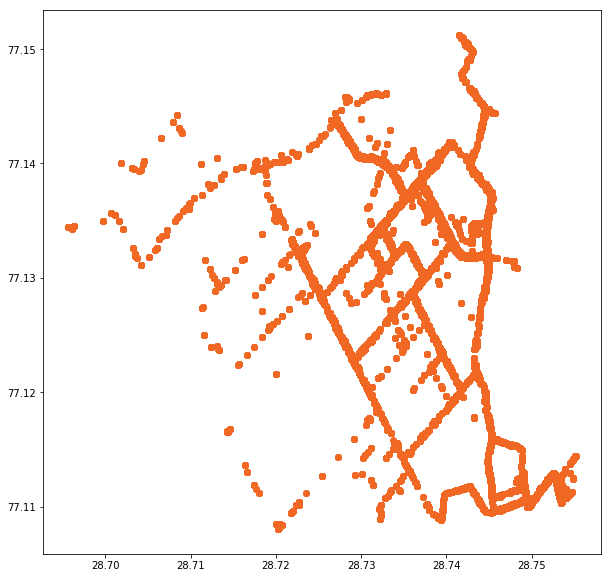

In [ ]:
x = [p.coords.xy[0] for p in points]
y = [p.coords.xy[1] for p in points]
pl.figure(figsize=(10,10))
_ = pl.plot(x,y,'o', color='#f16824')

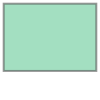

In [ ]:
point_collection = geometry.MultiPoint(list(points))
point_collection.envelope

## Define the fucntions to fit rectangle

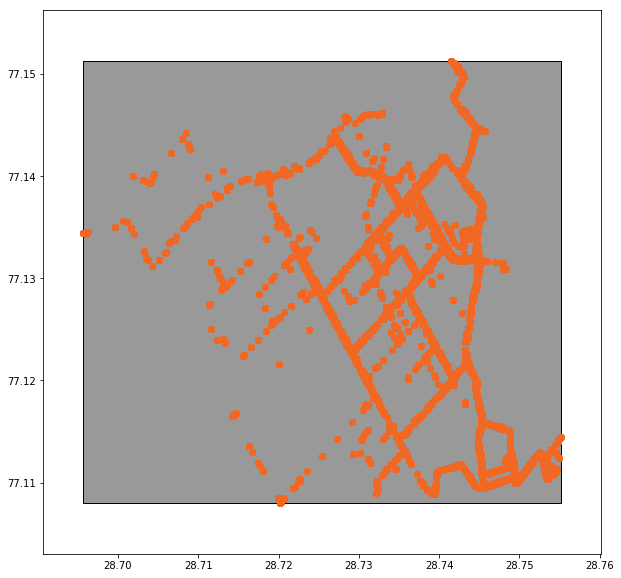

In [ ]:
def plot_polygon(polygon):
    fig = pl.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    margin = .005
    x_min, y_min, x_max, y_max = polygon.bounds
    ax.set_xlim([x_min-margin, x_max+margin])
    ax.set_ylim([y_min-margin, y_max+margin])
    patch = PolygonPatch(polygon, fc='#999999',
                         ec='#000000', fill=True,
                         zorder=-1)
    ax.add_patch(patch)
    return fig

_ = plot_polygon(point_collection.envelope)
_ = pl.plot(x,y,'o', color='#f16824')

## Fit a convex shape

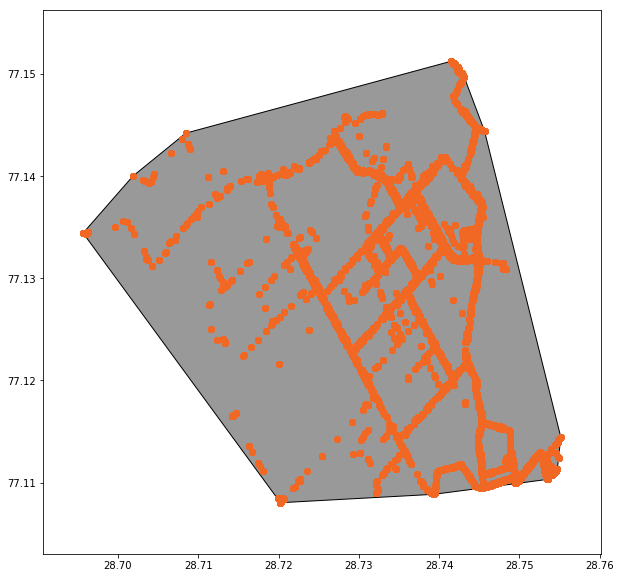

In [ ]:
convex_hull_polygon = point_collection.convex_hull
_ = plot_polygon(convex_hull_polygon)
_ = pl.plot(x,y,'o', color='#f16824')

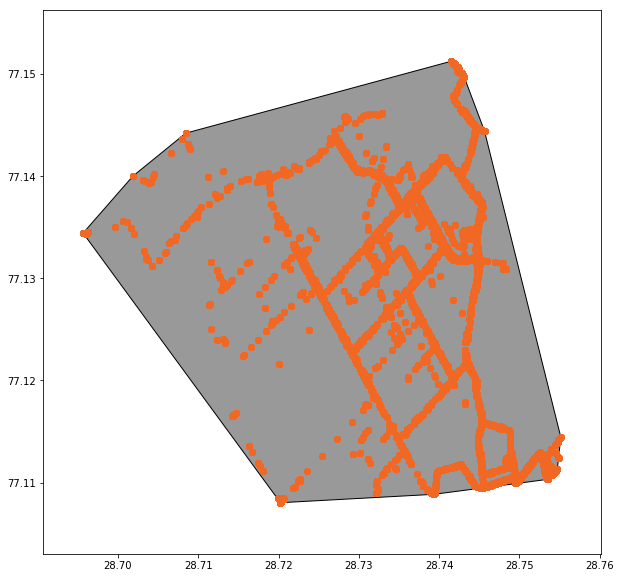

In [ ]:
from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
import numpy as np
import math
def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return geometry.MultiPoint(list(points)).convex_hull
    def add_edge(edges, edge_points, coords, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
                # already added
            return 
        edges.add( (i, j) ) 
        edge_points.append(coords[ [i, j] ])
    coords = np.array([point.coords[0]
                       for point in points])
    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the
    # triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]
        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
        # Semiperimeter of triangle
        s = (a + b + c)/2.0
        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        if area > 0:
            circum_r = a*b*c/(4.0*area)
        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)
    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    return cascaded_union(triangles), edge_points
concave_hull, edge_points = alpha_shape(points,alpha=1.87)
_ = plot_polygon(concave_hull)
_ = pl.plot(x,y,'o', color='#f16824')

## ConcaveHull + shape + LineCollection 

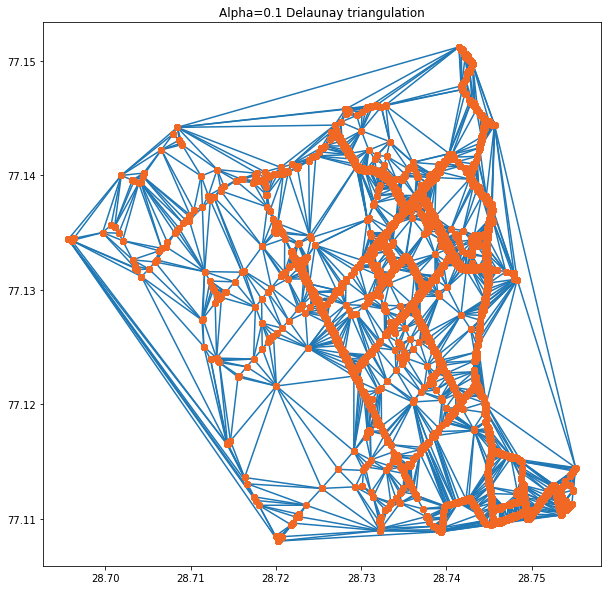

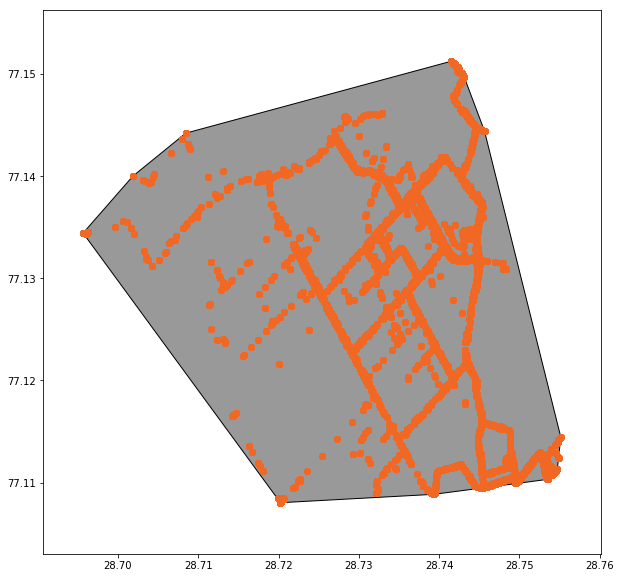

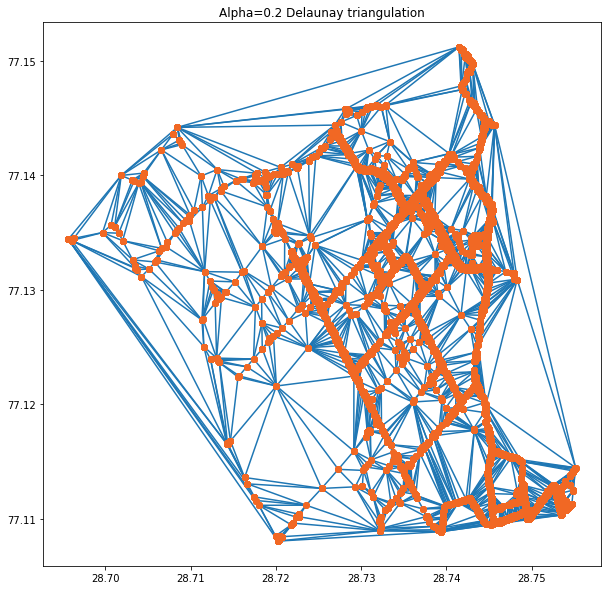

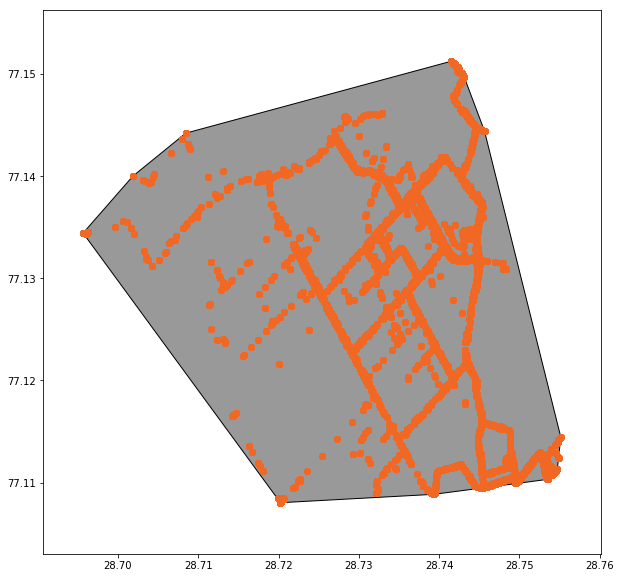

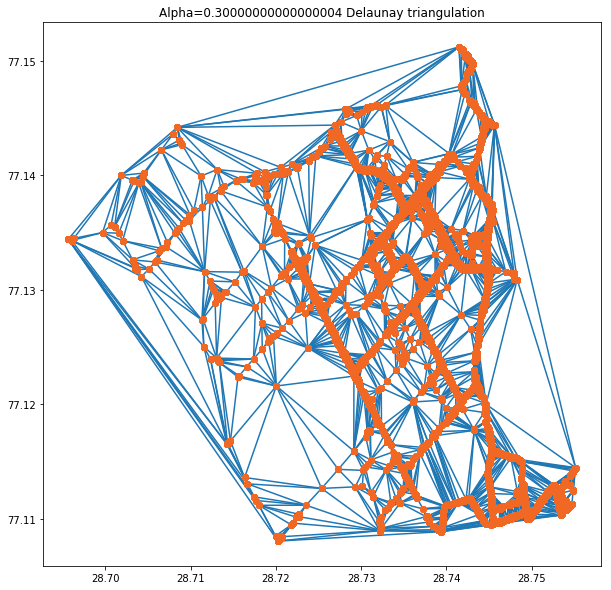

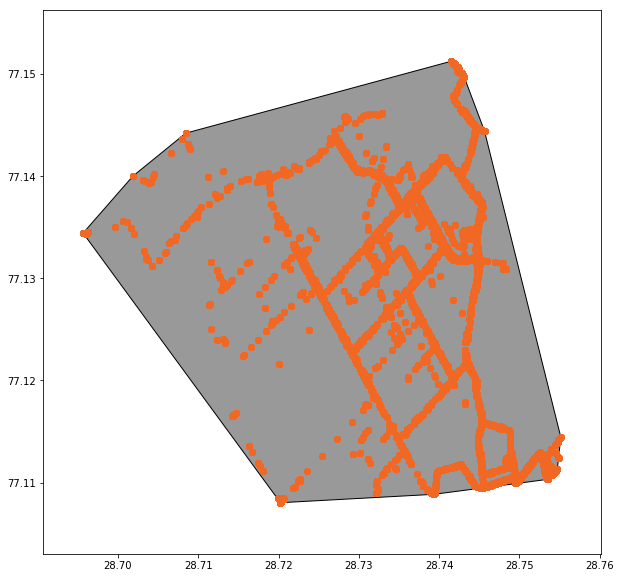

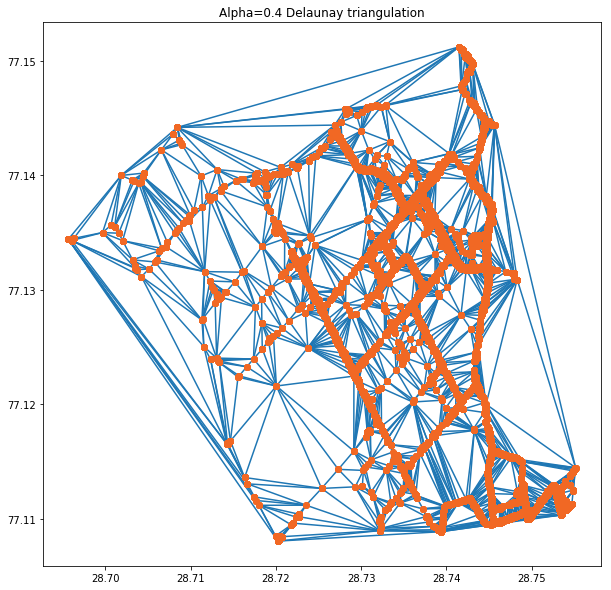

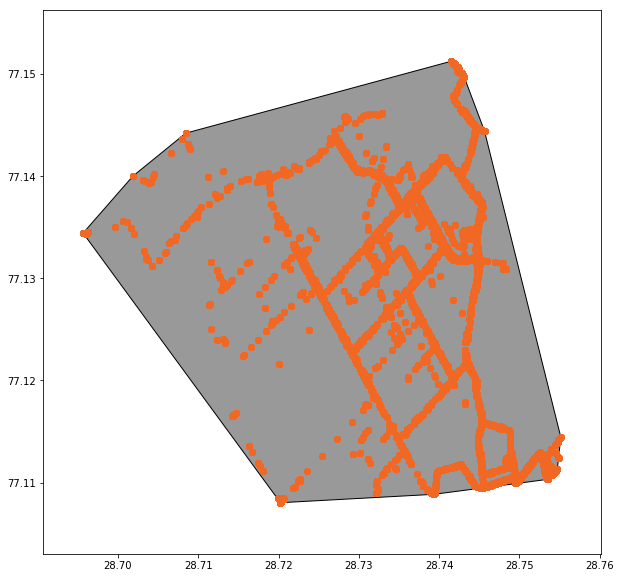

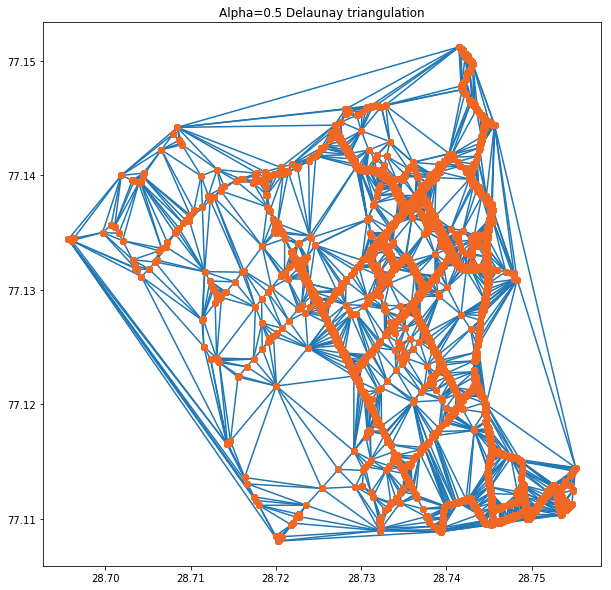

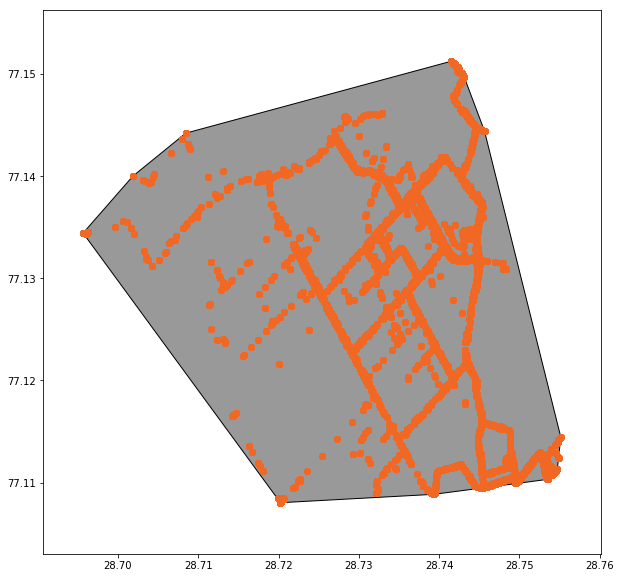

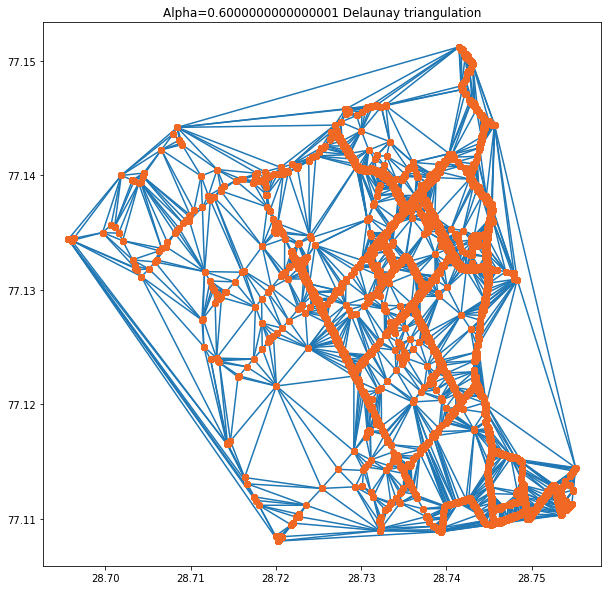

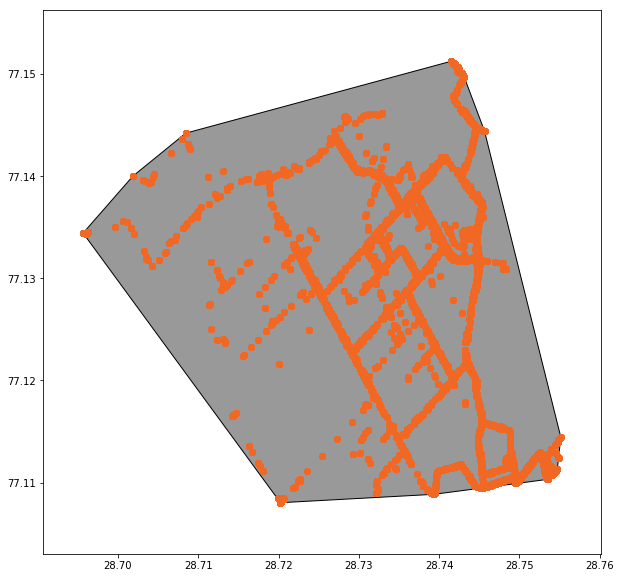

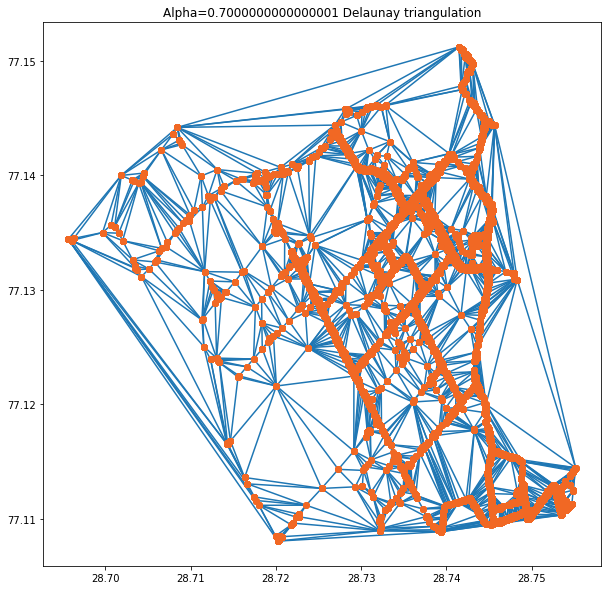

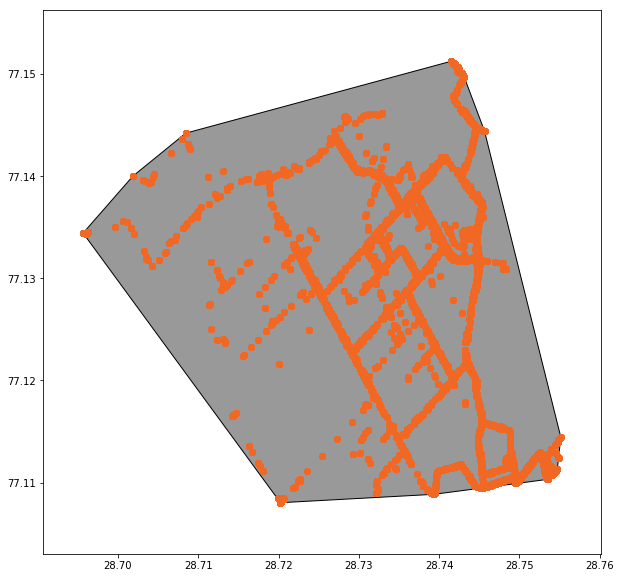

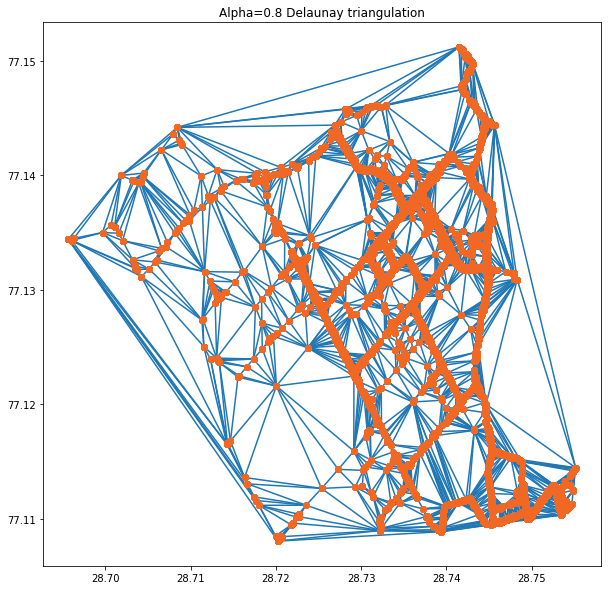

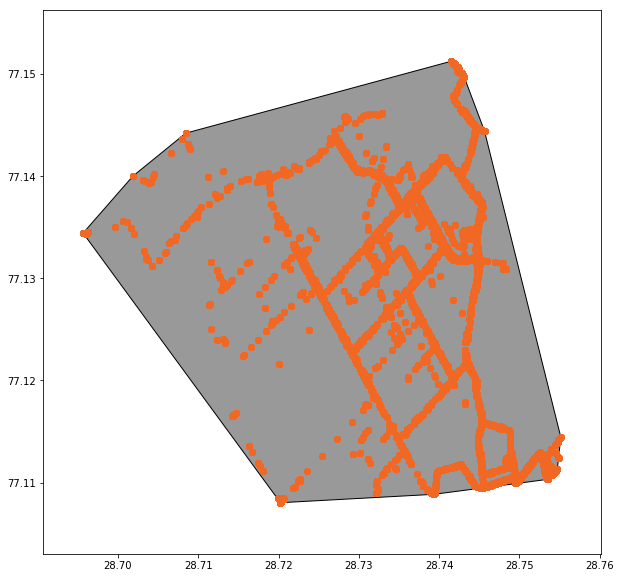

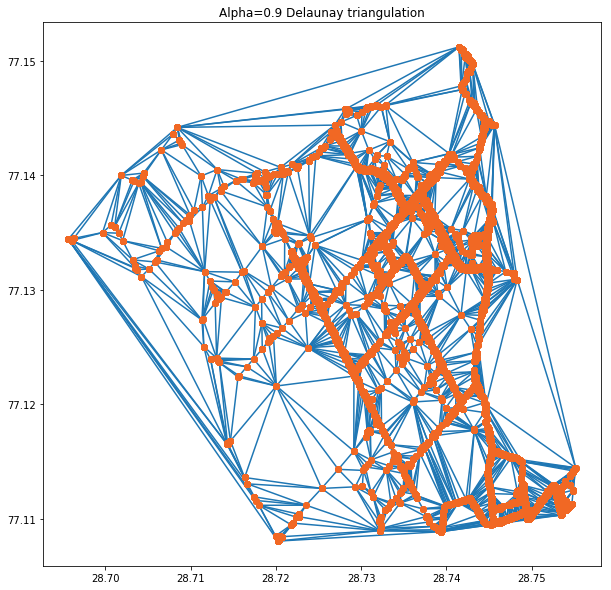

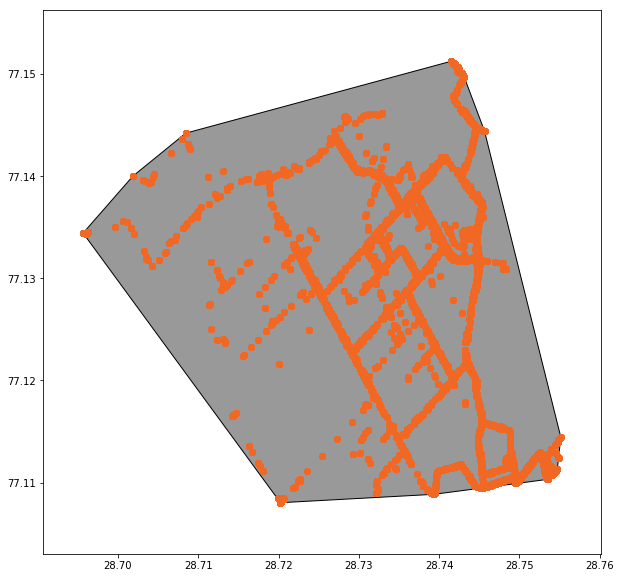

In [ ]:
from matplotlib.collections import LineCollection
for i in range(9):
    alpha = (i+1)*.1
    concave_hull, edge_points = alpha_shape(points, alpha=alpha)
    #print concave_hull
    lines = LineCollection(edge_points)
    pl.figure(figsize=(10,10))
    pl.title('Alpha={0} Delaunay triangulation'.format(alpha))
    pl.gca().add_collection(lines)
    delaunay_points = np.array([point.coords[0]
                                for point in points])
    pl.plot(delaunay_points[:,0], delaunay_points[:,1], 'o', color='#f16824')

    _ = plot_polygon(concave_hull)
    _ = pl.plot(x,y,'o', color='#f16824')

## ConcaveHull_buffer_in_Lat/Long

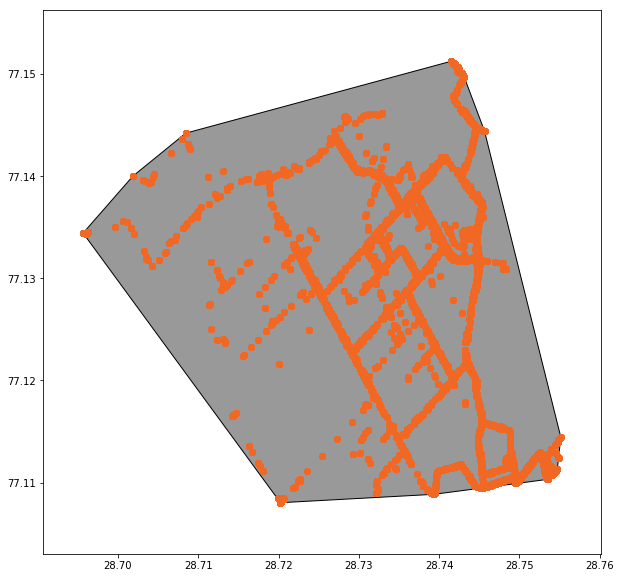

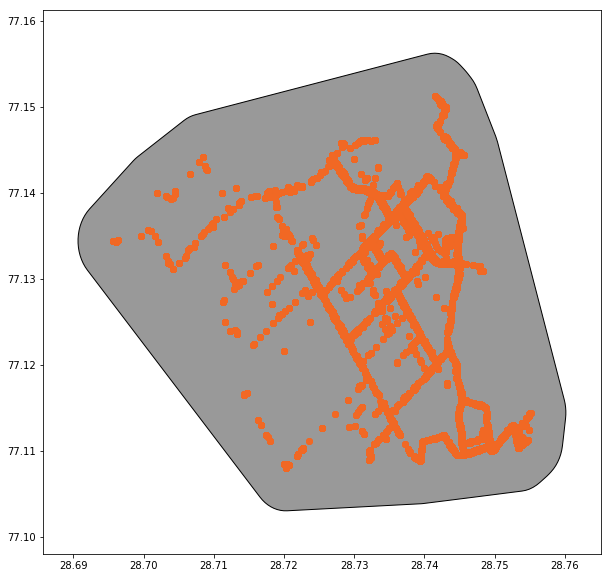

In [ ]:
alpha = .5
concave_hull, edge_points = alpha_shape(points,alpha=alpha)

plot_polygon(concave_hull)
_ = pl.plot(x,y,'o', color='#f16824')

plot_polygon(concave_hull.buffer(0.005))
_ = pl.plot(x,y,'o', color='#f16824')

## ConcaveHull_buffer_in_meters

In [ ]:
import pyproj
from functools import partial
from shapely.ops import transform


def buffer_in_meters(hull, meters):
        proj_meters = pyproj.Proj(init='epsg:3857')
        proj_latlng = pyproj.Proj(init='epsg:4326')

        project_to_meters = partial(pyproj.transform, proj_latlng, proj_meters)
        project_to_latlng = partial(pyproj.transform, proj_meters, proj_latlng)

        hull_meters = transform(project_to_meters, hull)
        print(type(hull_meters))
        print(hull_meters)
        buffer_meters = hull_meters.buffer(meters,cap_style=CAP_STYLE, join_style=JOIN_STYLE)
        buffer_latlng = transform(project_to_latlng, buffer_meters)
        return buffer_latlng

<class 'shapely.geometry.polygon.Polygon'>
POLYGON ((3200932.587365492 13909291.89992891, 3200825.34958936 13908940.07725975, 3200812.54784792 13908905.9772502, 3199932.381740714 13908496.79099695, 3199246.653677427 13908181.60196093, 3197122.677793091 13907772.46100445, 3194386.073644423 13920951.0028274, 3195076.811084796 13923739.61124111, 3195808.551204278 13925840.60340328, 3199486.547180089 13929362.1119002, 3199524.395806958 13929284.52153814, 3199580.055552354 13929065.10431224, 3199603.432645419 13928966.66095231, 3199656.866001002 13928713.05098469, 3199951.30605415 13925944.00297658, 3201009.02674917 13910973.92359064, 3200978.042824233 13909963.99203398, 3200960.231705707 13909401.69243618, 3200932.587365492 13909291.89992891))
<class 'shapely.geometry.polygon.Polygon'>
POLYGON ((3200932.587365492 13909291.89992891, 3200825.34958936 13908940.07725975, 3200812.54784792 13908905.9772502, 3199932.381740714 13908496.79099695, 3199246.653677427 13908181.60196093, 3197122.6777930

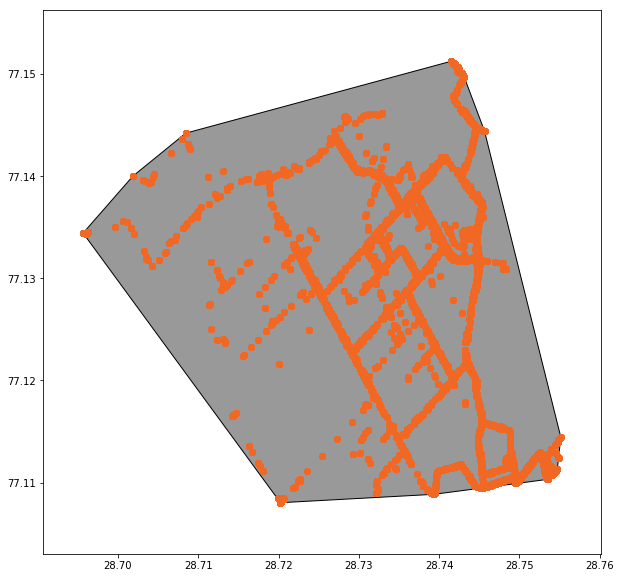

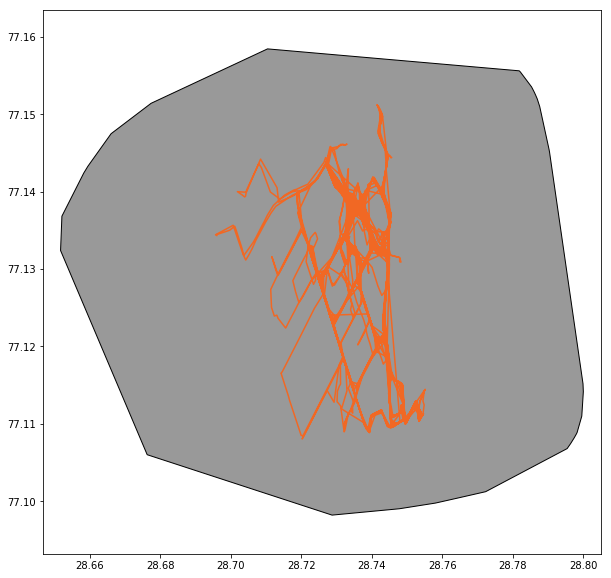

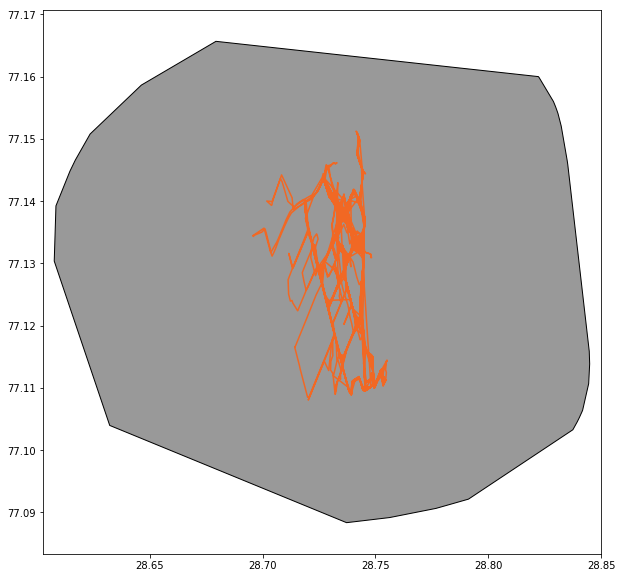

In [ ]:
alpha = .8
concave_hull, edge_points = alpha_shape(points,alpha=alpha)

plot_polygon(concave_hull)
_ = pl.plot(x,y,'o', color='#f16824')

# 5 KM = 5000 meters
concav_hull1 = buffer_in_meters(concave_hull, 5000)
plot_polygon(concav_hull1)
_ = pl.plot(x,y,'b', color='#f16824')

# 10 KM = 10000 meters
concav_hull3= buffer_in_meters(concave_hull, 10000)
plot_polygon(concav_hull3)
_ = pl.plot(x,y,'r', color='#f16824')

## Export the boundaries 

In [ ]:
# Original dataset
p, q = concave_hull.boundary.xy

P= np.matrix(p).flatten()
Q= np.matrix(q).flatten()

P = (pd.DataFrame(P)).transpose()
Q = (pd.DataFrame(Q)).transpose()

PQ = pd.concat([P,Q], axis=1, sort=False)

PQ.columns = ['lat','lon']

PQ_val = PQ.values

print(PQ_val)

concave_hull.centroid.bounds[:2]

[[28.75446667 77.11108   ]
 [28.75350333 77.110375  ]
 [28.75338833 77.11030667]
 [28.74548167 77.10948667]
 [28.73932167 77.108855  ]
 [28.72024167 77.108035  ]
 [28.69565833 77.13442167]
 [28.70186333 77.13999833]
 [28.70843667 77.14419833]
 [28.74147667 77.151235  ]
 [28.74181667 77.15108   ]
 [28.74231667 77.15064167]
 [28.74252667 77.150445  ]
 [28.74300667 77.14993833]
 [28.74565167 77.144405  ]
 [28.75515333 77.11445   ]
 [28.754875   77.11242667]
 [28.754715   77.1113    ]
 [28.75446667 77.11108   ]]


(28.728252318565666, 77.12864038756669)

In [ ]:
# 5KM dataset
p1, q1 = concav_hull1.boundary.xy

P1= np.matrix(p1).flatten()
Q1= np.matrix(q1).flatten()

P1 = (pd.DataFrame(P1)).transpose()
Q1= (pd.DataFrame(Q1)).transpose()

PQ1 = pd.concat([P1,Q1], axis=1, sort=False)

PQ1.columns = ['lat','lon']

PQ1_val = PQ1.values



In [ ]:
# 10KM dataset
p2, q2 = concav_hull3.boundary.xy

P2= np.matrix(p2).flatten()
Q2= np.matrix(q2).flatten()

P2 = (pd.DataFrame(P2)).transpose()
Q2 = (pd.DataFrame(Q2)).transpose()

PQ2 = pd.concat([P2,Q2], axis=1, sort=False)

PQ2.columns = ['lat','lon']

PQ2_val = PQ2.values

In [ ]:
center = [28.709445 , 77.097107]

pm3= folium.Map(center, zoom_start=11)

In [ ]:
# Create the map and add the line
my_PolyLine=folium.PolyLine(locations=PQ_val,weight=2, color= 'blue')
my_PolyLine1=folium.PolyLine(locations=PQ1_val,weight=2, color= 'green')
my_PolyLine2=folium.PolyLine(locations=PQ2_val,weight=2, color= 'red')
pm3.add_children(my_PolyLine)
pm3.add_children(my_PolyLine1)
pm3.add_children(my_PolyLine2)

/home/lpe-015/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning:

Method `add_children` is deprecated. Please use `add_child` instead.

/home/lpe-015/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning:

Method `add_children` is deprecated. Please use `add_child` instead.

/home/lpe-015/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning:

Method `add_children` is deprecated. Please use `add_child` instead.



In [ ]:
# Save map
pm3.save("map_boundary_B033_Deepak.html")

## Point in Polygon 

In [ ]:
def inside_polygon(x, y, points):
    """
    Return True if a coordinate (x, y) is inside a polygon defined by
    a list of verticies [(x1, y1), (x2, x2), ... , (xN, yN)].

    Reference: http://www.ariel.com.au/a/python-point-int-poly.html
    """
    n = len(points)
    inside = False
    p1x, p1y = points[0]
    for i in range(1, n + 1):
        p2x, p2y = points[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or x <= xinters:
                        inside = not inside
        p1x, p1y = p2x, p2y
    return inside

In [ ]:
x= 28.78
y= 78.90

# original database
points = [(x1,z1),(p2,y2),(x2,z2), (p1,y1) ]

In [ ]:
pointss = points

inside_polygon(x, y, PQ2_val)

False

In [ ]:
# concav_hull3.centroid.bounds

(28.730447894177964, 77.12820730964516, 28.730447894177964, 77.12820730964516)

In [ ]:
#circle = Point(x, y).buffer(1000.0)

In [ ]:
#circle = Point(buffer_latlng.centroid.bounds[:2]).buffer(111)

In [ ]:
#buffer_latlng

In [ ]:
#x = transform(project_to_meters, Point(buffer_latlng.centroid.bounds[:2]) ).buffer(5000)

In [ ]:
#transform(project_to_latlng, buffer_latlng).buffer(100)

In [ ]:
# from functools import partial
# import pyproj
# from shapely.ops import transform
# from shapely.geometry import Point

# proj_wgs84 = pyproj.Proj(init='epsg:4326')


# def geodesic_point_buffer(lat, lon, km):
#     # Azimuthal equidistant projection
#     aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
#     project = partial(
#         pyproj.transform,
#         pyproj.Proj(aeqd_proj.format(lat=lat, lon=lon)),
#         proj_wgs84)
#     buf = Point(0, 0).buffer(km * 1000)  # distance in metres
#     return transform(project, buf).exterior.coords[:]

In [ ]:
# lat,lon = buffer_latlng.centroid.bounds[:2]
# km = 5
# points = geodesic_point_buffer(lat, lon, km)

In [ ]:
# asd=[]
# for i,j in points:
#     asd.append({j,i})
# asd

In [ ]:
#pd.DataFrame(asd).to_csv('should_be_circle.csv')

In [ ]:
# concav_hull1 = buffer_in_meters(concave_hull, 5000)
# plot_polygon(concav_hull1)
# _ = pl.plot(x,y,'b', color='#f16824')

# proj_meters = pyproj.Proj(init='epsg:3857')
# proj_latlng = pyproj.Proj(init='epsg:4326')

# project_to_meters = partial(pyproj.transform, proj_latlng, proj_meters)
# project_to_latlng = partial(pyproj.transform, proj_meters, proj_latlng)


# hull_meters = transform(project_to_meters,concave_hull)
# buffer_meters = hull_meters.buffer(5000)
# buffer_latlng = transform(project_to_latlng, buffer_meters)


# def geodesic_point_buffer(lat, lon, km):
#     # Azimuthal equidistant projection
#     aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
#     project = partial(
#         pyproj.transform,
#         pyproj.Proj(aeqd_proj.format(lat=lat, lon=lon)),
#         proj_wgs84)
#     buf = Point(0, 0).buffer(km * 1000)  # distance in metres
#     return transform(project, buf).exterior.coords[:]

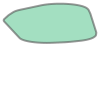

In [ ]:
buffer_latlng

In [ ]:
# print(PQ_val)
# concave_hull.centroid.bounds[:2]

# geom =  concave_hull
# geom_aea = transform(
# partial(
#     pyproj.transform,
#     pyproj.Proj(init='EPSG:4326'),
#     pyproj.Proj(
#         proj='aea',
#         lat1=geom.bounds[1],
#         lat2=geom.bounds[3])),
# geom)

# geom_aea.buffer(5000)

[[28.75446667 77.11108   ]
 [28.75350333 77.110375  ]
 [28.75338833 77.11030667]
 [28.74548167 77.10948667]
 [28.73932167 77.108855  ]
 [28.72024167 77.108035  ]
 [28.69565833 77.13442167]
 [28.70186333 77.13999833]
 [28.70843667 77.14419833]
 [28.74147667 77.151235  ]
 [28.74181667 77.15108   ]
 [28.74231667 77.15064167]
 [28.74252667 77.150445  ]
 [28.74300667 77.14993833]
 [28.74565167 77.144405  ]
 [28.75515333 77.11445   ]
 [28.754875   77.11242667]
 [28.754715   77.1113    ]
 [28.75446667 77.11108   ]]


(28.728252318565666, 77.12864038756669)

In [ ]:
def angleFromCoordinate(lat1, long1,  lat2,long2):

    dLon = (long2 - long1);

    y = math.sin(dLon) * math.cos(lat2);
    x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1)* math.cos(lat2) * math.cos(dLon);

    brng = math.atan2(y, x);

    brng = math.degrees(brng);
    brng = (brng + 360) % 360;
    brng = 360 - brng; # count degrees counter-clockwise - remove to make clockwise

    return brng;

In [ ]:
b =angleFromCoordinate(28.708307297777583, 77.07414392344755,  28.702995,77.045165)

In [ ]:
import geopy
from geopy.distance import VincentyDistance

# given: lat1, lon1, b = bearing in degrees, d = distance in kilometers
lat1, lon1= 28.702995 , 77.045165
d =  5

origin = geopy.Point(lat1, lon1)
destination = VincentyDistance(kilometers=d).destination(origin, b)

lat2, lon2 = destination.latitude, destination.longitude

/home/lpe-015/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning:

Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.



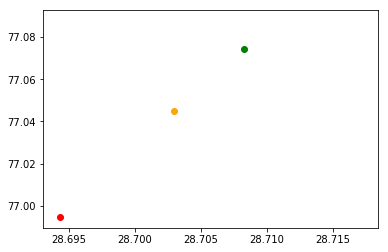

In [ ]:
plt.scatter(28.708307297777583, 77.07414392344755,color='green')
plt.scatter(28.702995,77.045165,color='orange')
plt.scatter(lat2 ,lon2,color='red')

In [ ]:
from haversine import haversine
haversine([28.702995,77.045165],[lat2 ,lon2])

4.991505667015369

/home/lpe-015/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning:

Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.

/home/lpe-015/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning:

Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.



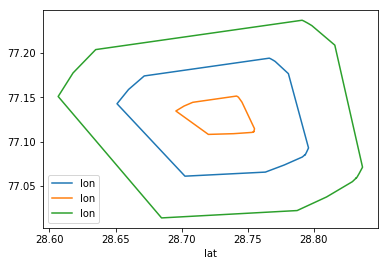

In [ ]:
# https://stackoverflow.com/questions/7222382/get-lat-long-given-current-point-distance-and-bearing

PQ_val = PQ.values

centeroid = concave_hull.centroid.bounds[:2]
fiveKm =[]
tenKm = []
inner = 5
outer = 10

for i in PQ_val:
    b =angleFromCoordinate(centeroid[0], centeroid[1] , i[0],i[1])
    # given: lat1, lon1, b = bearing in degrees, d = distance in kilometers
    lat1, lon1= i[0] , i[1]
    origin = geopy.Point(lat1, lon1)
    
    destination = VincentyDistance(kilometers=inner).destination(origin, b)
    fiveKm.append([destination.latitude, destination.longitude])
    destination = VincentyDistance(kilometers=outer).destination(origin, b)
    tenKm.append([destination.latitude, destination.longitude])

ax = pd.DataFrame(fiveKm,columns=['lat','lon']).plot(x='lat',y='lon')

ax1 = pd.DataFrame(PQ_val,columns=['lat','lon']).plot(x='lat',y= 'lon',ax = ax)

pd.DataFrame(tenKm,columns=['lat','lon']).plot(x='lat',y= 'lon',ax = ax1)

In [ ]:
center = [28.709445 , 77.097107]

pm66= folium.Map(center, zoom_start=11)

my_PolyLine=folium.PolyLine(locations=PQ_val,weight=2, color= 'blue')
my_PolyLine1=folium.PolyLine(locations=fiveKm,weight=2, color= 'green')
my_PolyLine2=folium.PolyLine(locations=tenKm,weight=2, color= 'red')
pm66.add_children(my_PolyLine)
pm66.add_children(my_PolyLine1)
pm66.add_children(my_PolyLine2)

/home/lpe-015/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning:

Method `add_children` is deprecated. Please use `add_child` instead.

/home/lpe-015/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning:

Method `add_children` is deprecated. Please use `add_child` instead.

/home/lpe-015/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning:

Method `add_children` is deprecated. Please use `add_child` instead.

